In [0]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.resnet50 import ResNet50

In [0]:
!gdown https://drive.google.com/uc?id=1xs6edsDRb5ktm8BMPJb-GtKOXxFqiJKv
!unzip seed_dataset.zip 

In [0]:
def focal_loss(gamma=2., alpha=2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [37]:
tf.random.set_seed(999)
img_size = 128

base_model = Xception(input_shape=(img_size, img_size,3), weights='imagenet',include_top=False)

base_model.trainable = True

classifier = Sequential([GlobalAveragePooling2D(),
                         Dense(512, activation='relu'),
                         Dropout(0.5),
                         Dense(256, activation='relu'),
                         Dropout(0.5),
                         Dense(3, activation='softmax')])

model = Sequential()
model.add(base_model)
model.add(classifier)
model.compile(optimizer= Adam(lr = 0.0001) ,loss=focal_loss(alpha = 2),metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
sequential_8 (Sequential)    (None, 3)                 1181187   
Total params: 22,042,667
Trainable params: 21,988,139
Non-trainable params: 54,528
_________________________________________________________________


In [38]:
tf.random.set_seed(999)

train_datagen = ImageDataGenerator(brightness_range = (0.2,1),
                                   rescale = 1./255,
                                   rotation_range=90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode='constant',
                                  validation_split = 0.25)

training_path = '/content/seed_dataset/train'
training_set = train_datagen.flow_from_directory(training_path,
                                                 target_size = (img_size, img_size),
                                                 batch_size = 32,
                                                 class_mode='categorical'
                                                subset = 'training')

valid_set = train_datagen.flow_from_directory(training_path,
                                            target_size = (img_size, img_size),
                                            batch_size = 512,
                                            class_mode='categorical',
                                            subset = 'validation',
                                            shuffle = False)

test_datagen = ImageDataGenerator(rescale = 1./255)

test_path = '/content/seed_dataset/test'
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (img_size, img_size),
                                            batch_size = 512,
                                            shuffle = False,
                                            class_mode='categorical')

Found 10982 images belonging to 3 classes.
Found 2748 images belonging to 3 classes.


In [0]:
EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [40]:
h = model.fit(training_set,
                    steps_per_epoch = training_set.n // training_set.batch_size,
                    epochs = EPOCHS,
                    validation_data = test_set,
                    validation_steps = test_set.n // test_set.batch_size,
                    callbacks=[early_stop] )

Epoch 1/1000
343/343 [==============================] - 87s 252ms/step - loss: 0.0524 - accuracy: 0.8717 - val_loss: 0.0171 - val_accuracy: 0.9613
Epoch 2/1000
343/343 [==============================] - 87s 252ms/step - loss: 0.0133 - accuracy: 0.9616 - val_loss: 0.0096 - val_accuracy: 0.9766
Epoch 3/1000
343/343 [==============================] - 87s 252ms/step - loss: 0.0088 - accuracy: 0.9754 - val_loss: 0.0059 - val_accuracy: 0.9848
Epoch 4/1000
343/343 [==============================] - 87s 253ms/step - loss: 0.0076 - accuracy: 0.9784 - val_loss: 0.0053 - val_accuracy: 0.9832
Epoch 5/1000
343/343 [==============================] - 86s 251ms/step - loss: 0.0063 - accuracy: 0.9843 - val_loss: 0.0057 - val_accuracy: 0.9883
Epoch 6/1000
343/343 [==============================] - 86s 251ms/step - loss: 0.0054 - accuracy: 0.9836 - val_loss: 0.0082 - val_accuracy: 0.9859
Epoch 7/1000
343/343 [==============================] - 86s 252ms/step - loss: 0.0048 - accuracy: 0.9858 - val_loss: 0

In [29]:
score = model.evaluate(training_set, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

275/275 [==============================] - 40s 147ms/step - loss: 0.0021 - accuracy: 0.9934
Test loss: 0.00210363557562232
Test accuracy: 0.9933993220329285


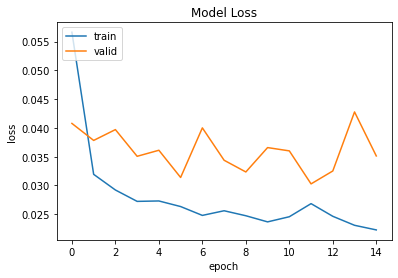

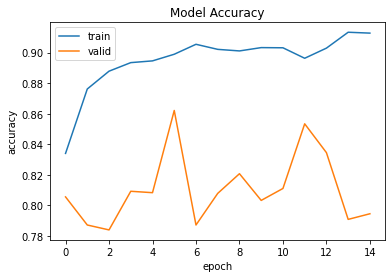

In [0]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train','valid'], loc='upper left')
plt.show()

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [0]:
Y_pred = model.predict_generator(valid_set, valid_set.n // valid_set.batch_size + 1, verbose = 1)
y_pred = np.argmax(Y_pred, axis=1)

5/5 [==============================] - 7s 1s/step


In [31]:
Y_pred = model.predict_generator(test_set,  test_set.n // test_set.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [34]:
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=None))

Confusion Matrix
[[1490    0    9]
 [   0  113    2]
 [   8    7 1119]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1499
           1       0.94      0.98      0.96       115
           2       0.99      0.99      0.99      1134

    accuracy                           0.99      2748
   macro avg       0.98      0.99      0.98      2748
weighted avg       0.99      0.99      0.99      2748



In [0]:
model.save('Model/model.h5')

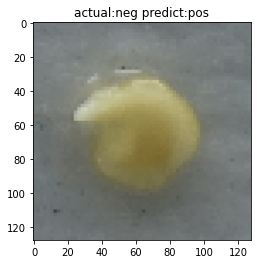

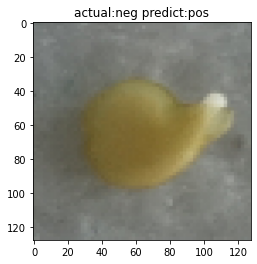

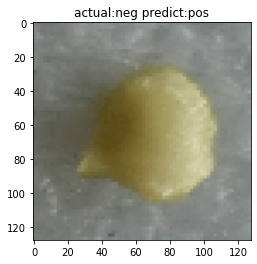

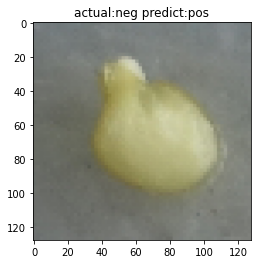

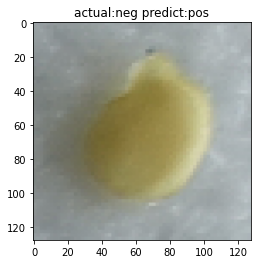

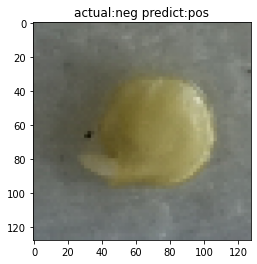

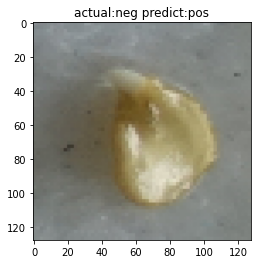

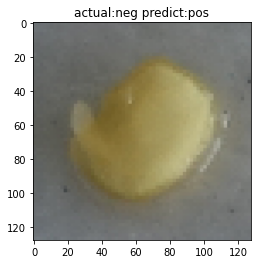

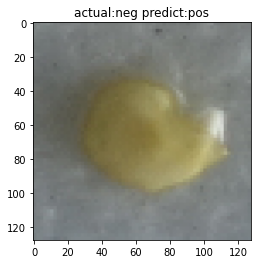

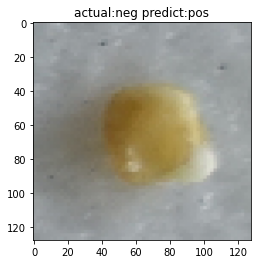

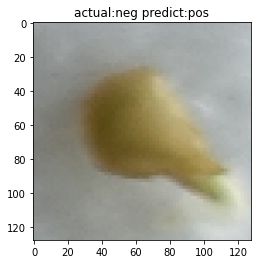

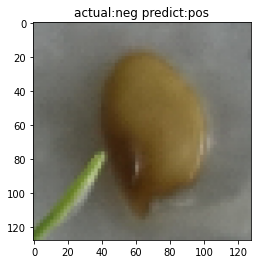

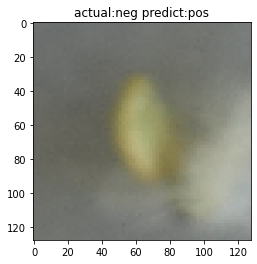

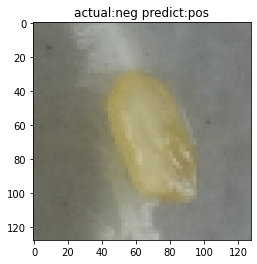

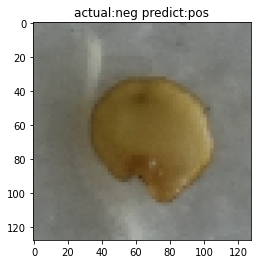

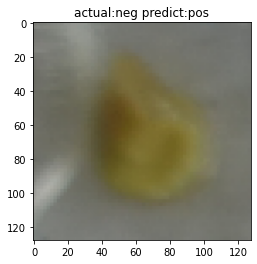

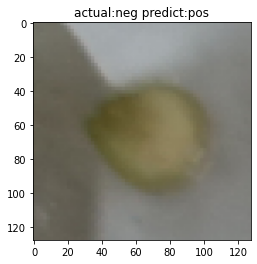

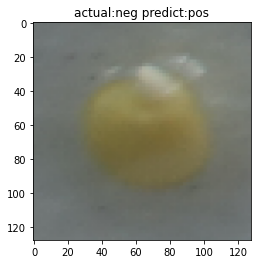

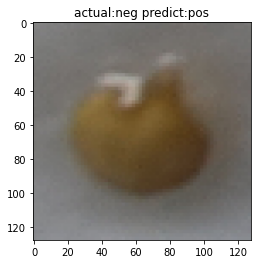

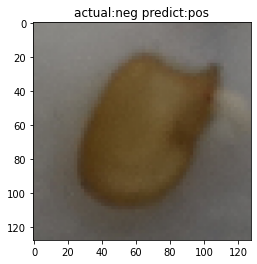

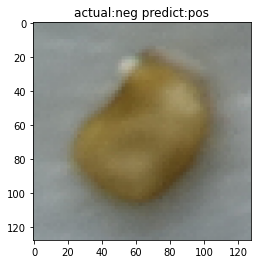

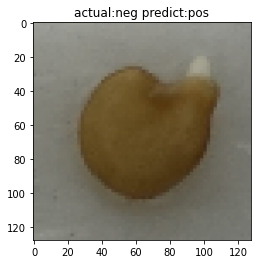

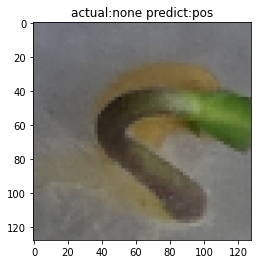

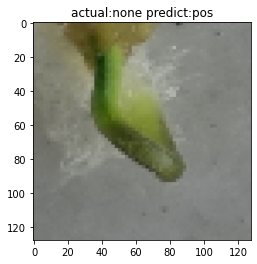

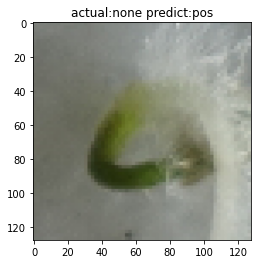

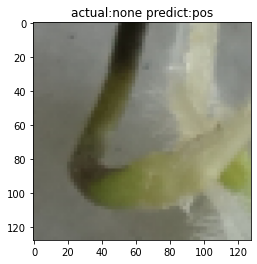

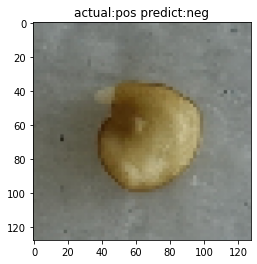

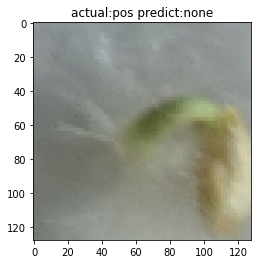

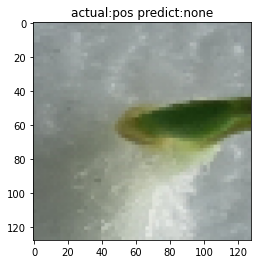

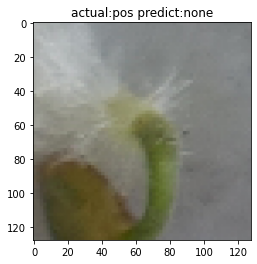

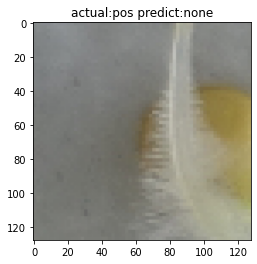

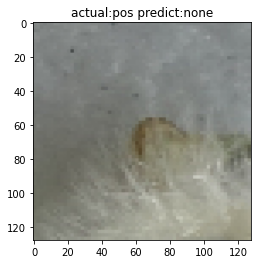

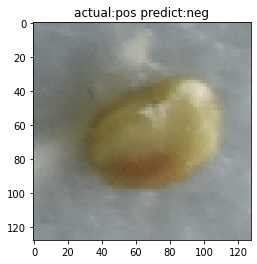

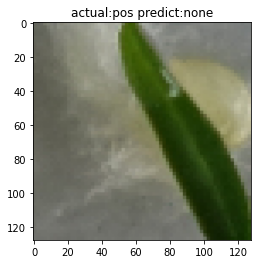

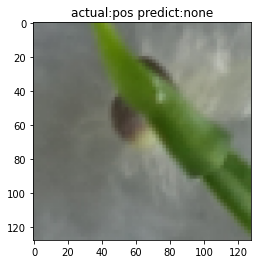

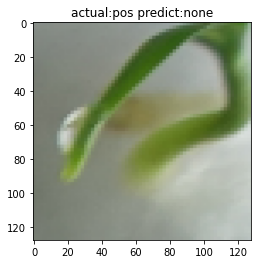

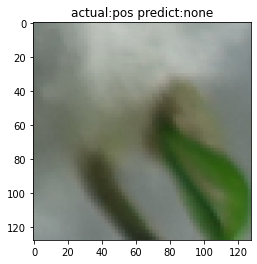

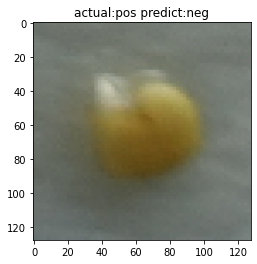

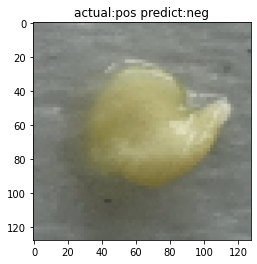

In [50]:
for data, ac, pr in wrong:
  plt.imshow(data)
  plt.title(f'actual:{class_name[ac]} predict:{class_name[pr]}')
  plt.show()